In [1]:
import os
from pathlib import Path

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set_context("paper")
sns.set(style="whitegrid")

from nilearn import plotting
import nibabel as nb

from scipy.stats import zscore

import statsmodels.formula.api as smf
from statsmodels.stats import weightstats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

## Load data

In [2]:
full_sample = pd.read_csv("full_sample_stats.tsv", sep="\t", index_col=0).drop("sub-10298")
copes_task = pd.read_csv("FSL_task/copes.tsv", sep="\t", index_col=0)
copes_hrv = pd.read_csv("FSL_hrv/copes.tsv", sep="\t", index_col=0)
hrv = pd.read_csv("mri_sample_hrv.tsv", sep="\t", index_col=0)

# Handle outliers in HRV
for var in hrv.columns:
    m = hrv[var].mean()
    median = hrv[var].median()
    sd = hrv[var].std()
    out = abs((hrv[var] - m) / sd) > 2.5
    hrv[var][out] = median

## Behavioural: task performance
| Data labels | Terms used in the manuscript |
|-------------|------------------------------|
|Accuracy  |  Accuracy|
|Sensibility | Confidence|
|Awareness | Insight|

In [3]:
from scipy.stats import ttest_1samp

tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="control"], 0.5)
print(f"HeartAcc control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartAcc"][full_sample["group"]=="patient"], 0.5)
print(f"HeartAcc patient: t = {tstat:.3f}, p = {pval:.3f}")

tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="control"], 25)
print(f"HeartSensib control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartSensib"][full_sample["group"]=="patient"], 25)
print(f"HeartSensib patient: t = {tstat:.3f}, p = {pval:.3f}")


tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="control"], 0.50)
print(f"HeartAware control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["HeartAware"][full_sample["group"]=="patient"], 0.50)
print(f"HeartAware patient: t = {tstat:.3f}, p = {pval:.3f}")

HeartAcc control : t = -0.130, p = 0.898
HeartAcc patient: t = 0.893, p = 0.377
HeartSensib control : t = 2.118, p = 0.047
HeartSensib patient: t = 3.277, p = 0.002
HeartAware control : t = 0.346, p = 0.733
HeartAware patient: t = 0.583, p = 0.563


In [4]:
tstat, pval= ttest_1samp(full_sample["NoteAcc"][full_sample["group"]=="control"], 0.5)
print(f"NoteAcc control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteAcc"][full_sample["group"]=="patient"], 0.5)
print(f"NoteAcc patient: t = {tstat:.3f}, p = {pval:.3f}")

tstat, pval= ttest_1samp(full_sample["NoteSensib"][full_sample["group"]=="control"], 25)
print(f"NoteSensib control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteSensib"][full_sample["group"]=="patient"], 25)
print(f"NoteSensib patient: t = {tstat:.3f}, p = {pval:.3f}")


tstat, pval= ttest_1samp(full_sample["NoteAware"][full_sample["group"]=="control"], 0.50)
print(f"NoteAware control : t = {tstat:.3f}, p = {pval:.3f}")
tstat, pval= ttest_1samp(full_sample["NoteAware"][full_sample["group"]=="patient"], 0.50)
print(f"NoteAware patient: t = {tstat:.3f}, p = {pval:.3f}")

NoteAcc control : t = 8.057, p = 0.000
NoteAcc patient: t = 8.957, p = 0.000
NoteSensib control : t = 9.105, p = 0.000
NoteSensib patient: t = 11.409, p = 0.000
NoteAware control : t = 3.106, p = 0.006
NoteAware patient: t = 4.735, p = 0.000


/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hw1012/projects/critchley_depersonalisation/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

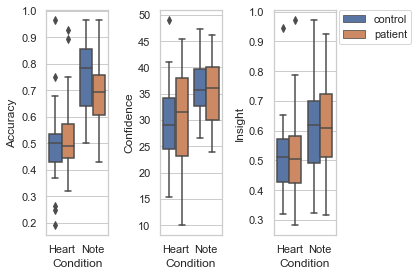

In [5]:
fig, ax =  plt.subplots(1, 3)
i = 0
for s, measure in zip(["Acc", "Sensib", "Aware"], ["Accuracy", "Confidence", "Insight"]):
    plot_data = full_sample[[f"Heart{s}", f"Note{s}", "group"]]
    plot_data["participant_id"] = plot_data.index
    plot_data = plot_data.melt(id_vars=["participant_id", "group"])
    plot_data.columns = ["participant_id", "Group", "Condition", measure]
    plot_data = plot_data.replace(f"Heart{s}", "Heart")
    plot_data = plot_data.replace(f"Note{s}", "Note")
    g = sns.boxplot(x="Condition", y=measure, hue="Group", 
                    data=plot_data, ax=ax[i])
    if i < 2:
        g.legend_.remove()
    else: 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    i += 1
plt.tight_layout()
plt.savefig("figures/task_performance.png", dpi=300)

## Behavioural data - CDS subscale  x metacognition in patients

#### Descriptive correlation: metacognitive insight (awareness)

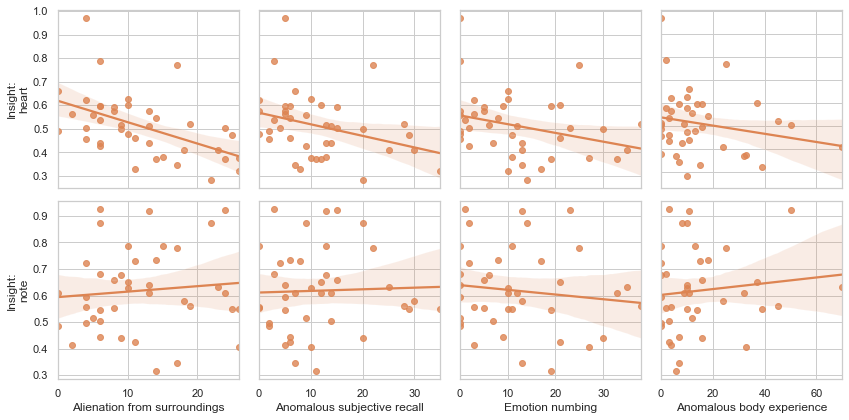

In [6]:
fep_desc = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "HeartAware", "NoteAware"]
desc_plot = full_sample[fep_desc][full_sample["group"] == "patient"]
# desc_plot["HeartNoteAware_bias"] = np.log(full_sample["HeartAware"] / full_sample["NoteAware"])

select_name = ["Alienation from surroundings", 
               "Anomalous subjective recall", 
               "Emotion numbing", 
               "Anomalous body experience", 
               "Insight:\nheart",
               "Insight:\nnote",
#                "Metacognitive insight:\nlog(heart/note)"
              ]

desc_plot.columns = select_name
i = 0
fig, axes = plt.subplots(len(select_name[4:]), 4, figsize=(12, 6))
for i, x in enumerate(select_name[:4]):
    for j, y in enumerate(select_name[4:]):
        g = sns.regplot(x=x, y=y, data=desc_plot, ax=axes[j, i],
                        color=sns.color_palette()[1])
        if i != 0:
            g.set_ylabel("")
            g.set(yticklabels=[])
        if j != len(select_name[4:]) - 1:
            g.set_xlabel("")
            g.set(xticklabels=[])

plt.tight_layout()
plt.savefig(f"figures/desc_CDStrait_insight_subscale.png", dpi=300)

In [7]:
full_sample[["CDS_State"]][full_sample["group"]=="control"].describe()

,CDS_State
count,21.000000
mean,120.761905
std,192.503741
min,2.000000
25%,25.000000
50%,54.000000
75%,114.000000
max,877.000000


In [8]:
full_sample[["CDS_State", "TotDuration"]][full_sample["group"]=="patient"].describe()

,CDS_State,TotDuration
count,40.00000,40.000000
mean,304.75000,28.000000
std,298.81988,21.178121
min,0.00000,0.000000
25%,59.00000,14.500000
50%,197.00000,25.500000
75%,492.25000,41.000000
max,1144.00000,89.000000


CDS_State: t(56.35690933747776) = -2.910204228254159, p = 0.005163192288285354


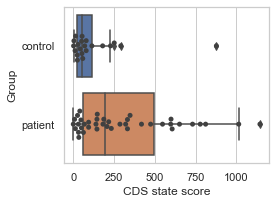

In [9]:
tstat, pval, df = weightstats.ttest_ind(full_sample["CDS_State"][full_sample["group"]=="control"], 
                                        full_sample["CDS_State"][full_sample["group"]=="patient"],
                                        usevar="unequal")
print(f"CDS_State: t({df}) = {tstat}, p = {pval}")
plot_data = full_sample[["group", "CDS_State"]]
plot_data.columns = ["Group", "CDS state score"]


plt.figure(figsize=(4,3))
sns.boxplot(y="Group", x="CDS state score",data=plot_data,)
sns.swarmplot(y="Group", x="CDS state score", data=plot_data, color=".25")
plt.tight_layout()
plt.savefig("figures/cds_ttest.png", dpi=300)

### CDS subscales vs metacognition

In [10]:
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "HeartAware", "NoteAware"]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]
# fep_stat["HeartNoteAware_bias"] = np.log(full_sample["HeartAware"] / full_sample["NoteAware"])
# fep_stat["HeartNoteAcc_bias"] = np.log(full_sample["HeartAcc"] / full_sample["NoteAcc"])

#### Models

In [11]:
mod = smf.ols(formula=f'HeartAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:             HeartAware   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     3.499
Date:                Fri, 05 Mar 2021   Prob (F-statistic):             0.0167
Time:                        17:25:56   Log-Likelihood:                -50.030
No. Observations:                  40   AIC:                             110.1
Df Residuals:                      35   BIC:                             118.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -6.87e-16      0.143  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.008933,0.043874
AnomSubRecTot,0.991472,0.999927
EmoNumTot,0.638616,0.952804
AnomBodyExpTot,0.224747,0.638779


In [12]:
mod = smf.ols(formula=f'NoteAware ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, method='holm-sidak', is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:              NoteAware   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.120
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.363
Time:                        17:25:56   Log-Likelihood:                -54.349
No. Observations:                  40   AIC:                             118.7
Df Residuals:                      35   BIC:                             127.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.11e-16      0.159  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.425542,0.810428
AnomSubRecTot,0.783111,0.952959
EmoNumTot,0.059305,0.263380
AnomBodyExpTot,0.173304,0.532928


### Plot CDS subscale analysis

In [13]:
# rename some variables for viz
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "HeartAware"]
fep_stat = full_sample[fep_stat][full_sample["group"] == "patient"]

select_name = ["Alienation from surroundings", 
               "Anomalous subjective recall", 
               "Emotion numbing", 
               "Anomalous body experience", 
               "Interoceptive insight"
              ]
fep_stat.columns = select_name

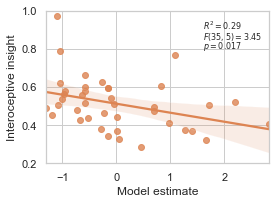

In [14]:
sns.set_context("paper")
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))
g = sns.regplot(x=zscore(fep_stat[select_name[:-1]].values.sum(axis=1)), 
                y=select_name[-1], 
                data=fep_stat,
                color=sns.color_palette()[1])
g.set_ylim(0.2, 1)
g.set_xlabel("Model estimate")
g.annotate(r"$R^{2}=0.29$", (1.6, 0.90), fontsize=8)
g.annotate(r"$F(35, 5)=3.45$", (1.6, 0.85), fontsize=8)
g.annotate(r"$p=0.017$", (1.6, 0.8), fontsize=8)
plt.tight_layout()
plt.savefig("figures/metacog_CDStrait_model.png", dpi=300)

['Anomalous subjective recall', 'Emotion numbing', 'Anomalous body experience']
['Alienation from surroundings', 'Emotion numbing', 'Anomalous body experience']
['Alienation from surroundings', 'Anomalous subjective recall', 'Anomalous body experience']
['Alienation from surroundings', 'Anomalous subjective recall', 'Emotion numbing']


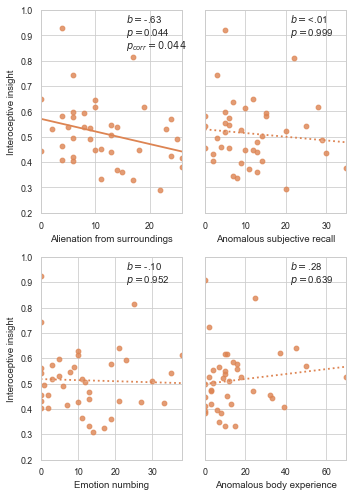

In [15]:
sns.set_context("paper")
i = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 7))
for x, stats in zip(select_name[:-1], 
                    [("-.63", "0.044"),
                     ("<.01", "0.999"),
                     ("-.10", "0.952"),
                     (".28", "0.639")
                    ]):
    ci = False 
    partial = [i for i in select_name[:-1] if i != x]
    print(partial)
    if x == "Alienation from surroundings":
        ci = True
    g = sns.regplot(x=x, y=select_name[-1], data=fep_stat, 
                    y_partial=zscore(fep_stat[partial].values.sum(axis=1)),
                    fit_reg=True, ax=axes[int(i/2), np.mod(i, 2)],
                    color=sns.color_palette()[1], ci=ci
                   )
    if x != "Alienation from surroundings":
        g.lines[0].set_linestyle(":")
    g.set_ylim(0.2, 1)
    g.set_ylabel("Interoceptive insight")
    g.set_xlim(0, fep_stat[x].max())
    if np.mod(i, 2) != 0:
        g.set_ylabel("")
        g.set(yticklabels=[])
        
    g.annotate(r"$b=$" + stats[0], (fep_stat[x].max() - fep_stat[x].max() * 0.4, 0.95))
    g.annotate(r"$p=$" + stats[1], (fep_stat[x].max() - fep_stat[x].max() * 0.4, 0.9))
    if i ==0:
        g.annotate(r"$p_{corr}=0.044$", (fep_stat[x].max() - fep_stat[x].max() * 0.4, 0.85))
    
    i += 1

plt.tight_layout()
plt.savefig(f"figures/metacog_CDStrait_subscale.png", dpi=300)

## Task fMRI - Introception > extroception

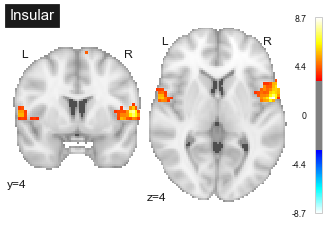

In [16]:
sig_tstat = "FSL_task/heart_wrt_note_thresh_tstat.nii.gz"

d = nb.load(sig_tstat).get_fdata()
vmax = d.max()
thr = np.unique(d)[1]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
g = plotting.plot_stat_map(sig_tstat,  title="Insular",
                       display_mode="yz",
                       cut_coords=(4, 4), 
                       draw_cross=False, colorbar=False,
                       axes=ax
                      )
g._colorbar_margin = {'left':0,
                      'right': -0.2,
                      'top': 0.037750000000000006,
                      'bottom': 0.037750000000000006}

g._show_colorbar(cmap="cold_hot", 
                 norm=colors.Normalize(-vmax, vmax), 
                 threshold=thr)

plt.savefig("figures/insular.png", dpi=300)

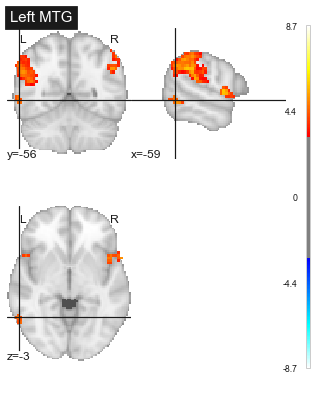

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
g = plotting.plot_stat_map(sig_tstat, title="Left MTG",
                       display_mode="tiled",
                       cut_coords=(-59, -56, -3),
                       draw_cross=True, colorbar=False,
                       axes=ax
                      )
g._colorbar_margin = {'left':0,
                      'right': -0.2,
                      'top': 0.037750000000000006,
                      'bottom': 0.037750000000000006}

g._show_colorbar(cmap="cold_hot", 
                 norm=colors.Normalize(-vmax, vmax), 
                 threshold=thr)
plt.savefig("figures/LMTG.png", dpi=300)

In [18]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats = stats[['insular_L', 'insular_R', 'MTG_L', "CDS_State", "HeartAware", "RMSSD"]]

In [19]:
for x in ['insular_L', 'insular_R', 'MTG_L']:
    for y in ["CDS_State", "HeartAware", "RMSSD"]:
        mod = smf.ols(formula=f'{y} ~ {x} ', data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     5.825
Date:                Fri, 05 Mar 2021   Prob (F-statistic):             0.0198
Time:                        17:26:02   Log-Likelihood:                -66.666
No. Observations:                  49   AIC:                             137.3
Df Residuals:                      47   BIC:                             141.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.684e-17      0.138    3.4e-16      1.0

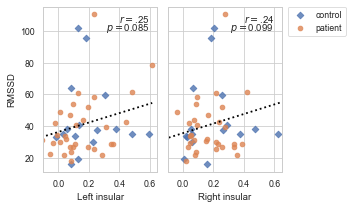

In [20]:
stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
select_name = ["Left insular", "Right insular","RMSSD","Group"]
select_var = ["insular_L", "insular_R", 
              "RMSSD", "group"]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

for (i, region), stats in zip(enumerate(["Left insular", "Right insular"]),
                              [(".25", "0.085"),
                               (".24", "0.099")]):
    
    axes[i].scatter(data[data["Group"] == "control"][region], 
                 data[data["Group"] == "control"]["RMSSD"], 
                 label="control", marker="D", alpha=0.8)
    axes[i].scatter(data[data["Group"] == "patient"][region], 
                 data[data["Group"] == "patient"]["RMSSD"],
                 label="patient", marker="o", alpha=0.8)
    
    g = sns.regplot(region, "RMSSD", data=data, ax=axes[i], 
                fit_reg=True, scatter=False, ci=None, color="black")
    g.lines[0].set_linestyle(":")
    g.set_xlim(-0.1, 0.65)
    if i == 1:
        axes[i].set_ylabel("")
        axes[i].set(yticklabels=[])
    g.annotate(r"$r=$" + stats[0], (0.4, 105))
    g.annotate(r"$p=$" + stats[1], (0.31, 100))
        
        
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("figures/insular_vs_rmssd.png", dpi=300)

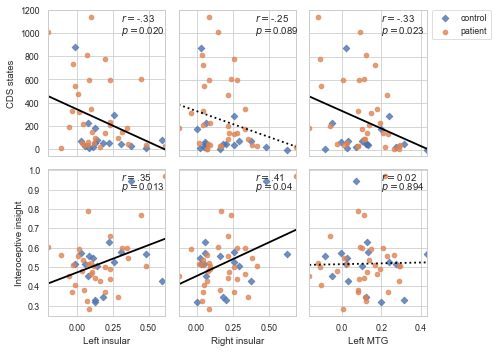

In [21]:
select_name = ["Left insular", "Right insular", "Left MTG",
               "CDS states", "Interoceptive insight","Group"
              ]
select_var = ["insular_L", "insular_R", "MTG_L",
              "CDS_State", "HeartAware", "group"]

stats = pd.concat([full_sample, hrv, copes_task], axis=1, join="inner")
stats = stats[select_var]

data = stats[select_var]
data.columns = select_name

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
stats = [[("-.33", "0.020"), ("-.25", "0.089"), ("-.33", "0.023")], 
         [(".35", "0.013"), (".41", "0.04"), ("0.02", "0.894")]]

for j, region in enumerate(["Left insular", "Right insular", "Left MTG"]):
    for i, measure in enumerate(["CDS states", "Interoceptive insight"]):
        axes[i, j].scatter(data[data["Group"] == "control"][region], 
                     data[data["Group"] == "control"][measure], 
                     label="control", marker="D", alpha=0.8)
        axes[i, j].scatter(data[data["Group"] == "patient"][region], 
                     data[data["Group"] == "patient"][measure],
                     label="patient", marker="o", alpha=0.8)
    
        g = sns.regplot(region, measure, data=data, 
                        fit_reg=True, scatter=False, ci=None, 
                        ax=axes[i, j], color="black")
        
        if j != 0:
            axes[i, j].set_ylabel("")
            axes[i, j].set(yticklabels=[])

        if i == 0:
            axes[i, j].set_xlabel("")
            axes[i, j].set(xticklabels=[])
        if ((measure == "CDS states" and region in ["Left insular", "Left MTG"]) or
            (measure == "Interoceptive insight" and region in ["Left insular","Right insular"])):
            g.lines[0].set_linestyle("-")
        else:
            g.lines[0].set_linestyle(":")
        
        if region =="Left insular":
            x = 0.31
        elif region =="Right insular":
            x = 0.4
        else:
            x = 0.2
        if measure == "CDS states":
            y1, y2 = 1100, 1000
        else:
            y1, y2 = 0.95, 0.9
            
        g.annotate(r"$r=$" + stats[i][j][0], (x, y1))
        g.annotate(r"$p=$" + stats[i][j][1], (x, y2))
            
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/copes_vs_beh_scatter_original.png", dpi=300)

In [22]:
fep_stat = ["AlienSurroundTot", "AnomSubRecTot", "EmoNumTot", "AnomBodyExpTot", "MTG_L"]
stats = pd.concat([full_sample, copes_task], axis=1, join="inner")
fep_stat = stats[fep_stat][stats["group"] == "patient"]

mod = smf.ols(formula=f'MTG_L ~ AlienSurroundTot + AnomSubRecTot + EmoNumTot + AnomBodyExpTot', 
              data=fep_stat.apply(zscore))
res = mod.fit()
print(res.summary())
reject, p_corrected, _, alphaBonf = multipletests(res.pvalues, is_sorted=False)
corrected_p = pd.DataFrame(res.pvalues.values, index=res.pvalues.index, columns=["uncorrected"])
corrected_p["corrected"] = p_corrected
corrected_p

                            OLS Regression Results                            
Dep. Variable:                  MTG_L   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9660
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.442
Time:                        17:26:04   Log-Likelihood:                -44.692
No. Observations:                  33   AIC:                             99.38
Df Residuals:                      28   BIC:                             106.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.388e-17      0.177  

,uncorrected,corrected
Intercept,1.000000,1.000000
AlienSurroundTot,0.414600,0.799387
AnomSubRecTot,0.209116,0.690569
EmoNumTot,0.267522,0.712142
AnomBodyExpTot,0.763823,0.944220


## Exploratory: continuous HRV in the task fMRI signal

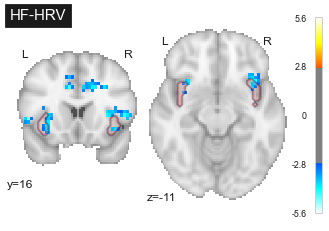

In [23]:
sig_tstat = "FSL_hrv/HFHRV_thresh_tstat.nii.gz"  # this is an inverse map

d = nb.load(sig_tstat).get_fdata()
vmax = d.max()
thr = np.unique(d)[1]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
g = plotting.plot_stat_map(sig_tstat,  title="HF-HRV",
                       display_mode="yz",
                       cut_coords=(16, -11),
                       draw_cross=False, colorbar=False,
                       cmap="cold_hot_r",
                       axes=ax
                      )
g.add_contours("FSL_hrv/harvardoxford-cortical_prob50_InsularCortex_L.nii.gz", alpha=0.2)
g.add_contours("FSL_hrv/harvardoxford-cortical_prob50_InsularCortex_R.nii.gz", alpha=0.2)

g._colorbar_margin = {'left':0,
                      'right': -0.2,
                      'top': 0.037750000000000006,
                      'bottom': 0.037750000000000006}

g._show_colorbar(cmap="cold_hot", 
                 norm=colors.Normalize(-vmax, vmax), 
                 threshold=thr)

plt.savefig("figures/HFHRV.png", dpi=300)

In [24]:
stats = pd.concat([full_sample, hrv, copes_hrv], axis=1, join="inner")
stats = stats[['insular_anatomical_L', 'insular_anatomical_R', "CDS_State", "HeartAware", "hf_power"]]

for x in ['insular_anatomical_L', 'insular_anatomical_R']:
    for y in ["CDS_State", "HeartAware", "hf_power"]:
        mod = smf.ols(formula=f'{y} ~ {x}', 
                      data=stats.apply(zscore))
        res = mod.fit()
        print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CDS_State   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.111
Date:                Fri, 05 Mar 2021   Prob (F-statistic):              0.297
Time:                        17:26:06   Log-Likelihood:                -68.955
No. Observations:                  49   AIC:                             141.9
Df Residuals:                      47   BIC:                             145.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.684e-17 

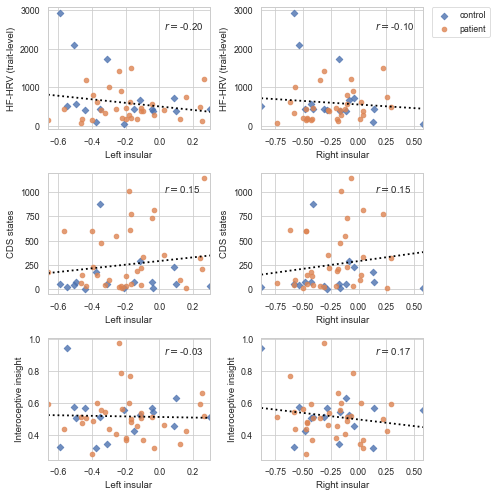

In [25]:
data = pd.concat([full_sample, hrv, copes_hrv], axis=1, join="inner")
select_name = ["Left insular", "Right insular", "HF-HRV (trait-level)",
               "CDS states", "Interoceptive insight","Group"
              ]
select_var = ["insular_anatomical_L", "insular_anatomical_R", "hf_power",
              "CDS_State", "HeartAware", "group"]
data = data[select_var]
data.columns = select_name

stats = [["-0.20", "-0.10"], 
         ["0.15", "0.15"],
         ["-0.03", "0.17"]]

fig, axes = plt.subplots(3, 2, figsize=(7, 7))

for j, region in enumerate(select_name[:2]):
    for i, measure in enumerate(select_name[2:-1]):
        axes[i, j].scatter(data[data["Group"] == "control"][region], 
                     data[data["Group"] == "control"][measure], 
                     label="control", marker="D", alpha=0.8)
        axes[i, j].scatter(data[data["Group"] == "patient"][region], 
                     data[data["Group"] == "patient"][measure],
                     label="patient", marker="o", alpha=0.8)
    
        g = sns.regplot(region, measure, data=data, 
                        fit_reg=True, scatter=False, ci=None, 
                        ax=axes[i, j], color="black")
        g.lines[0].set_linestyle(":")
        
        if region =="Left insular":
            x = 0.025
        elif region =="Right insular":
            x = 0.15

        if measure == "CDS states":
            y = 1000
        elif measure =="HF-HRV (trait-level)":
            y = 2500
        elif measure =="Interoceptive insight":
            y = 0.9
            
        g.annotate(r"$r=$" + stats[i][j], (x, y))
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

plt.savefig("figures/HFHRV_copes.png", dpi=300)